In [43]:
import glob
import sys
import os
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from functools import partial
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def data_load(path):
    files = glob.glob(path)
    if not files:
        print("Chck Phath")
        sys.exit()

    _feature=[]
    label=[]
    for address in tqdm.tqdm(files):
        label_ = os.path.basename(address)
        for num in glob.glob(address+'/*'):
            _feature.append(np.load(num))
            label.append([label_])
        print(label_)
    target = np.array(label).flatten()
    return _feature, target.reshape((-1,))

def data_split(feature, target):
    a_set, b_set, a_target, b_target = [], [], [], []
    arr = np.arange(80)
    np.random.seed(18)
    np.random.shuffle(arr)
    arr = np.split(arr,2)
    for batch in range(10):
        batch_feature_array = feature[0+80*batch:80+80*batch]
        batch_target_array = target[0+80*batch:80+80*batch]
        for count in arr[0]:
            a_set.append(batch_feature_array[count])
            a_target.append(batch_target_array[count])
        for count in arr[1]:
            b_set.append(batch_feature_array[count])
            b_target.append(batch_target_array[count])
    return np.array(a_set), np.array(b_set), np.array(a_target), np.array(b_target)


X_train, y_train = data_load('../train_data/*')
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)

X_test, y_test = data_load('../test_data/*')
y_test = encoder.transform(y_test)

X_test,  X_valid, y_test, y_valid = data_split(X_test, y_test)
X_train = np.array(X_train) / 255.0
X_valid = X_valid / 255.0
X_test = X_test / 255.0

y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test_raw = y_test.copy()
y_test = to_categorical(y_test)
number_of_classes = y_valid.shape[1]

 10%|█         | 1/10 [00:00<00:02,  3.20it/s]

around


 20%|██        | 2/10 [00:00<00:02,  3.23it/s]

b


 30%|███       | 3/10 [00:00<00:02,  3.19it/s]

fracture


 40%|████      | 4/10 [00:01<00:01,  3.29it/s]

ground


 50%|█████     | 5/10 [00:01<00:01,  3.37it/s]

mechanics


 60%|██████    | 6/10 [00:01<00:01,  3.39it/s]

science


 70%|███████   | 7/10 [00:02<00:00,  3.43it/s]

smile


 80%|████████  | 8/10 [00:02<00:00,  3.46it/s]

strain


 90%|█████████ | 9/10 [00:02<00:00,  3.48it/s]

stress


100%|██████████| 10/10 [00:02<00:00,  3.39it/s]

t



 40%|████      | 4/10 [00:00<00:00, 16.04it/s]

around
b
fracture
ground


 80%|████████  | 8/10 [00:00<00:00, 15.32it/s]

mechanics
science
smile
strain


100%|██████████| 10/10 [00:00<00:00, 15.59it/s]


stress
t


In [2]:

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3,padding="SAME")
model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=3, input_shape=[210, 210, 10]),
    DefaultConv2D(filters=64),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.Activation("relu"),
    keras.layers.MaxPooling2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=number_of_classes, activation="softmax"),
])
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=25, restore_best_weights=True)
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.RMSprop(learning_rate =0.0001),
              metrics=["accuracy",
                       keras.metrics.TopKCategoricalAccuracy(k=1, name='Top1'),
                       keras.metrics.TopKCategoricalAccuracy(k=2, name='Top2'),
                       keras.metrics.TopKCategoricalAccuracy(k=3, name='Top3')])
history = model.fit(X_train, y_train, epochs=300, callbacks=[callback], validation_data=(X_valid, y_valid))

score = model.evaluate(X_test,y_test)
print(score)


model.save("VGG2.h5")
np.save('history.npy',history.history)

Train on 4000 samples, validate on 400 samples
Epoch 1/300
4000/4000 [==============================] - 30s 7ms/sample - loss: 2.2642 - accuracy: 0.1340 - Top1: 0.1340 - Top2: 0.2573 - Top3: 0.3738 - val_loss: 2.0879 - val_accuracy: 0.2950 - val_Top1: 0.2950 - val_Top2: 0.4900 - val_Top3: 0.5800

In [3]:

history=np.load('history.npy',allow_pickle='TRUE').item()


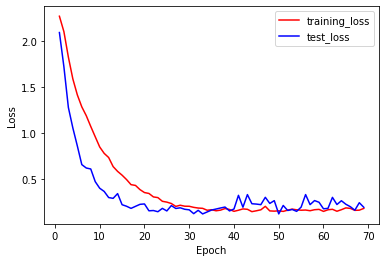

In [7]:
training_loss = history["loss"]
test_loss = history["val_loss"]
epoch_count = range(1, len(training_loss)+1)

training_acc = history["accuracy"]
test_acc = history["val_accuracy"]

plt.plot(epoch_count, training_loss, "r-")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["training_loss", "test_loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig('./figure/loss.png',dpi=300,bbox_inches='tight')

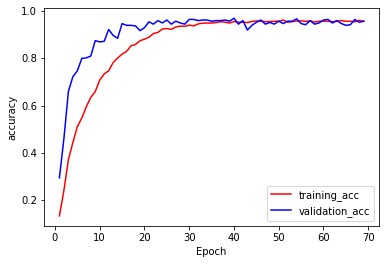

In [8]:
plt.plot(epoch_count, training_acc, "r-")
plt.plot(epoch_count, test_acc, "b-")
plt.legend(["training_acc", "validation_acc"])
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.savefig('./figure/acc.png',dpi=300,bbox_inches='tight')

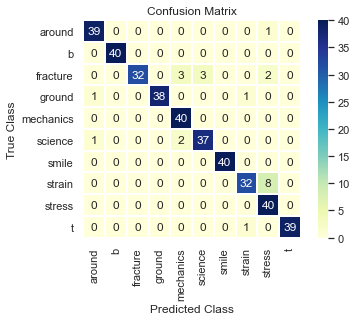

In [86]:

from sklearn.metrics import confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

y_prediction = model.predict(X_test)
labels=np.unique(encoder.inverse_transform(y_test_raw))
matrix = confusion_matrix(encoder.inverse_transform(y_test_raw), encoder.inverse_transform(np.argmax(y_prediction, axis=1)),
                          labels = np.unique(encoder.inverse_transform(y_test_raw)))
dataframe = pd.DataFrame(matrix, index = np.unique(encoder.inverse_transform(y_test_raw)), columns=np.unique(encoder.inverse_transform(y_test_raw)))
sns.heatmap(dataframe, annot=True, cmap="YlGnBu", linewidths=1, square=True)
plt.title("Confusion Matrix")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.savefig('./figure/heaat.png',dpi=300,bbox_inches='tight')
plt.show()

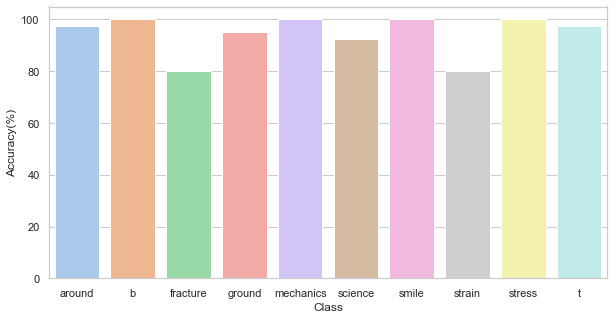

In [96]:
fig, ax = plt.subplots(figsize=(10,5))
sns.set_theme(style="whitegrid", palette='pastel')
sns.barplot(x=labels, y=[np.max(i)/40*100 for i in matrix])
ax.set_xlabel('Class')
ax.set_ylabel('Accuracy(%)')
plt.savefig('./figure/plot.png',dpi=300,bbox_inches='tight')

[0.975, 1.0, 0.8, 0.95, 1.0, 0.925, 1.0, 0.8, 1.0, 0.975]